In [13]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt
from sklearn.neighbors import NearestNeighbors
from sklearn.preprocessing import MinMaxScaler

df_pid = pd.read_csv('diabetes.csv', header=0, na_values = ['na','','-','.'], quotechar='"')
df_pid.describe()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
count,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000
mean,3.845052,120.894531,69.105469,20.536458,79.799479,31.992578,0.471876,33.240885,0.348958
std,3.369578,31.972618,19.355807,15.952218,115.244002,7.884160,0.331329,11.760232,0.476951
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.078000,21.000000,0.000000
25%,1.000000,99.000000,62.000000,0.000000,0.000000,27.300000,0.243750,24.000000,0.000000
50%,3.000000,117.000000,72.000000,23.000000,30.500000,32.000000,0.372500,29.000000,0.000000
75%,6.000000,140.250000,80.000000,32.000000,127.250000,36.600000,0.626250,41.000000,1.000000
max,17.000000,199.000000,122.000000,99.000000,846.000000,67.100000,2.420000,81.000000,1.000000


1. Compute the correlation between the different columns after removing the outcome column.

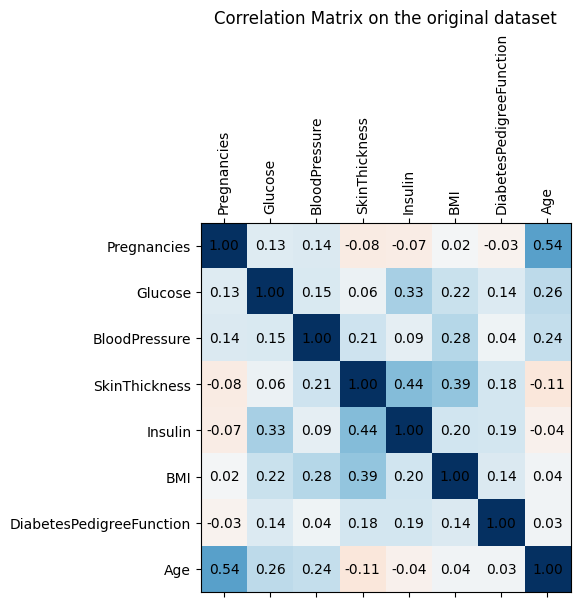

In [14]:
df_diabetes = df_pid[df_pid.columns[:-1]]

corrV1 = df_diabetes.corr()
def plot_correlation(corrv, title):
    fig, ax = plt.subplots()
    ax.matshow(corrv, cmap='RdBu', vmin=-1, vmax=1) 
    dim = len(corrv)
    for i in range(dim):
        for j in range(dim):
            c =  '{:.2f}'.format(corrv.iloc[i,j])
            ax.text(i,j,str(c), va='center', ha='center')
    cell_pos = np.arange(len(corrv.columns))
    ax.set_yticks(cell_pos, labels=corrv.columns)
    ax.set_xticks(cell_pos, labels=corrv.columns, rotation=90)
    plt.title(title)

    del i, j ,c , cell_pos

plot_correlation(corrV1, "Correlation Matrix on the original dataset")

2. Remove the disguised values from the table. We need to remove the values that equal to 0 from columns BloodPressure, SkinThickness and BMI as these are missing values but they have been replaced by the value 0. Remove the value but keep the record (i.e.) change the value to null.

In [15]:
blood_miss= df_diabetes["BloodPressure"]==0
skinth_miss = df_diabetes["SkinThickness"]==0
bmi_miss = df_diabetes["BMI"]==0


df_diabetes.loc[blood_miss, ["BloodPressure"]] = None
df_diabetes.loc[skinth_miss, ["SkinThickness"]] = None
df_diabetes.loc[bmi_miss, ["BMI"]] = None
# print Na values
print("Number of Na values for each attribute:")
df_diabetes.isna().sum()

Number of Na values for each attribute:


Pregnancies                   0
Glucose                       0
BloodPressure                35
SkinThickness               227
Insulin                       0
BMI                          11
DiabetesPedigreeFunction      0
Age                           0
dtype: int64

3. Fill the cells with null using the mean values of the records that have the same class label.

We used KNN to exclude the missing attributes from the attribute space, where k= 9. It was tried several K-values (k= 3,5,7). The missing values rate for SkinThickness is high (227 / 768), it was required to increase our chances of having neighbours with non-nan values, by increasing k.


In [16]:
def idxs_excluding(colnames):
    cols = []
    for c in range(len(df_diabetes.columns)):
        if df_diabetes.columns[c]  not in colnames:
            cols.append(c)
    return cols  


scaled =   MinMaxScaler(feature_range=(0,1)).fit_transform(df_diabetes)
input = scaled[:, idxs_excluding(('BloodPressure', 'SkinThickness', 'BMI'))]
knn = NearestNeighbors(n_neighbors=9, algorithm='ball_tree').fit(input )
knn_distances, knn_indexes =  knn.kneighbors(input)

 Missing values completion, and check if all was set.

In [17]:
# create an matrix to store neib means 

for i in range(len(knn_indexes)):
    
    if(skinth_miss[i].item() is True ):
        mean =  df_diabetes.iloc[knn_indexes[i]]['SkinThickness'].mean()
        df_diabetes.loc[i,'SkinThickness'] = mean
    if(blood_miss[i].item()):
        mean = df_diabetes.iloc[knn_indexes[i]]['BloodPressure'].mean() 
        df_diabetes.loc[i,'BloodPressure'] = mean
        
    if(bmi_miss[i].item()):
        mean = df_diabetes.iloc[knn_indexes[i]]['BMI'].mean() 
        df_diabetes.loc[i,'BMI'] = mean
        

print("Number of Na values for each attribute:")
df_diabetes.isna().sum()

Number of Na values for each attribute:


Pregnancies                 0
Glucose                     0
BloodPressure               0
SkinThickness               0
Insulin                     0
BMI                         0
DiabetesPedigreeFunction    0
Age                         0
dtype: int64

4. Compute the correlation between the different columns.

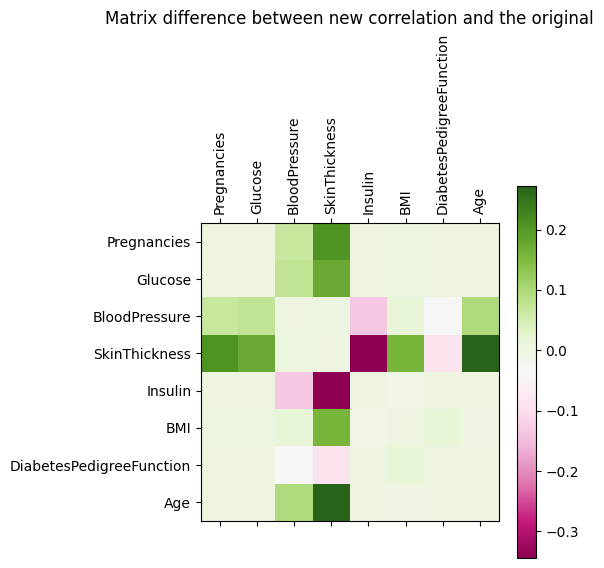

In [18]:
# calc
corrV2 = df_diabetes.corr()

correlation_diff = (corrV2.to_numpy() - corrV1.to_numpy())

# plot the difference 
plt.matshow(correlation_diff, cmap='PiYG')
plt.colorbar()
plt.title('Matrix difference between new correlation and the original')
plt.xticks(ticks=range(len(corrV2.columns)), labels=corrV2.columns, rotation=90) 
plt.yticks(ticks=range(len(corrV2.columns)), labels=corrV2.columns)  

plt.show()


5. Compare the values from this step with the values in the first step (just mention the most important changes (if any)) and comment on your findings. 

The replacement of missing values initially set as 0, with the median of the neighbours of each observation, impacted the correlation matrix results. The positive correlation increased between "SkinThickness" and "Pregnancies", "Glocuse" and "Age". Where the most significant change is the correlation ("SkinThickness", "Age"). Furthermore, the negative correlation between "SkinThickness" and "Insulin" became more pronounced. 

  